### Dependencies

In [22]:
# Use these commands to install required dependencies if necessary.

#!pip install pandas numpy matplotlib sklearn tensorflow

     |████████████████████████████████| 497.6 MB 5.1 kB/s  eta 0:00:01
     |████████████████████████████████| 1.0 MB 62.6 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 16.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 96.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 38.4 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 24.8 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.3 MB/s  eta 0:00:01
     |████████████████████████████████| 5.8 MB 89.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 126 kB 51.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 74.2 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 6.2 MB/s  eta 0:00:01
     |████████████████████████████████| 14.5 MB 85.9 MB/s eta 0:00:01
     |█████████████████████████████

#### Code To Ignore Warning Messages

In [4]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

### Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sqlite3
import os
from pprint import pprint

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [6]:
con = sqlite3.connect(os.path.join(os.getcwd(), "../Database/results.sqlite"))

### Pre-Processing

In [7]:
# Convert datatypes from string to appropriate numeric/date types, and display the Tweets table

tweet_df = pd.read_sql_query("SELECT * from new_scored_tweets WHERE category LIKE 'Gaming'", con)
tweet_df["date"] = tweet_df["date"].astype("datetime64")
tweet_df["count"] = tweet_df["count"].astype("int32")
tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float32")
tweet_df["ind_neu"] = tweet_df["ind_neu"].astype("float32")
tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float32")
tweet_df["wted_neg"] = tweet_df["wted_neg"].astype("float32")
tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float32")
tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float32")
tweet_df.head(10)

,category,date,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,Gaming,2020-04-08,106,1.521354,5.536829,3.941818,9.301545,34.890747,61.807709,12,31,63
1,Gaming,2020-04-09,30,0.095913,1.302829,1.601258,0.959129,13.028288,16.012581,0,20,10
2,Gaming,2020-04-20,50,0.063000,1.270316,3.666685,0.629995,12.703156,36.666851,0,10,40
3,Gaming,2020-04-26,30,0.013203,0.732399,1.254398,0.199808,13.939927,15.860261,0,20,10
4,Gaming,2020-05-05,90,0.813426,6.306322,5.880252,1.927296,48.122074,39.950630,2,55,33
5,Gaming,2020-05-21,90,0.818388,1.661397,1.520214,10.103505,35.756599,44.139893,10,20,60
6,Gaming,2020-05-22,129,0.387921,10.804465,7.807615,3.410609,76.495041,49.094349,0,87,42
7,Gaming,2020-05-23,160,1.407490,1.265239,1.327272,73.718452,64.911987,21.369551,130,20,10
8,Gaming,2020-06-03,110,0.721285,4.600916,3.677799,7.501625,63.857635,38.640736,0,70,40
9,Gaming,2020-06-07,680,0.031180,1.067889,3.900930,9.972553,334.228699,335.798737,0,610,70


In [8]:
# Display the Stocks table

stock_df = pd.read_sql_query("SELECT * from scored_stocks WHERE category LIKE 'Gaming'", con)
stock_df["agg_percent"] = pd.to_numeric(stock_df["agg_percent"], downcast="float")

stock_df["disc_agg_percent"] = (stock_df['agg_percent'] > 0)
stock_df["disc_agg_percent"] = stock_df["disc_agg_percent"].astype("int32")
stock_df["date"] = stock_df["date"].astype("datetime64")
stock_df.head(10)

,category,date,agg_percent,disc_agg_percent
0,Gaming,2020-04-08,-0.140,0
1,Gaming,2020-04-09,-0.188,0
2,Gaming,2020-04-20,0.496,1
3,Gaming,2020-04-26,-1.109,0
4,Gaming,2020-05-05,1.090,1
5,Gaming,2020-05-21,-2.102,0
6,Gaming,2020-05-22,2.218,1
7,Gaming,2020-05-23,-0.504,0
8,Gaming,2020-06-03,-3.454,0
9,Gaming,2020-06-07,2.561,1


In [9]:
# Merge the Tweets and Stocks table based on category and date.

merged_df = pd.merge(tweet_df, stock_df,on=["category", "date"]) 
merged_df = merged_df.sort_values(by=["category", "date"]).reset_index(drop=True)
merged_df

,category,date,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts,agg_percent,disc_agg_percent
0,Gaming,2020-04-07,110,2.065667,4.478648,3.455684,20.872316,52.542690,36.584991,20,60,30,-0.756,0
1,Gaming,2020-04-08,106,1.521354,5.536829,3.941818,9.301545,34.890747,61.807709,12,31,63,-0.140,0
2,Gaming,2020-04-09,30,0.095913,1.302829,1.601258,0.959129,13.028288,16.012581,0,20,10,-0.188,0
3,Gaming,2020-04-10,30,0.121644,1.627764,0.250591,2.257278,24.279539,3.463182,0,30,0,1.630,1
4,Gaming,2020-04-12,20,0.771991,0.202749,0.025260,15.439815,4.054986,0.505200,20,0,0,2.998,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,Gaming,2022-03-15,70,1.148857,4.346474,0.504668,11.761762,51.733074,6.505160,10,60,0,1.393,1
545,Gaming,2022-03-16,40,0.026352,0.868798,0.104850,1.054095,34.751915,4.193992,0,40,0,2.069,1
546,Gaming,2022-03-17,10,0.015381,0.889870,0.094749,0.153811,8.898700,0.947488,0,10,0,1.409,1
547,Gaming,2022-03-18,20,0.581220,0.662693,0.756087,5.812201,6.626925,7.560872,10,0,10,1.617,1


In [10]:
# Drop extraneous columns of information.

# merged_df['norm_score'] = merged_df['score']/merged_df['count']
df = merged_df.drop(columns = ['category'])
df

,date,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts,agg_percent,disc_agg_percent
0,2020-04-07,110,2.065667,4.478648,3.455684,20.872316,52.542690,36.584991,20,60,30,-0.756,0
1,2020-04-08,106,1.521354,5.536829,3.941818,9.301545,34.890747,61.807709,12,31,63,-0.140,0
2,2020-04-09,30,0.095913,1.302829,1.601258,0.959129,13.028288,16.012581,0,20,10,-0.188,0
3,2020-04-10,30,0.121644,1.627764,0.250591,2.257278,24.279539,3.463182,0,30,0,1.630,1
4,2020-04-12,20,0.771991,0.202749,0.025260,15.439815,4.054986,0.505200,20,0,0,2.998,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2022-03-15,70,1.148857,4.346474,0.504668,11.761762,51.733074,6.505160,10,60,0,1.393,1
545,2022-03-16,40,0.026352,0.868798,0.104850,1.054095,34.751915,4.193992,0,40,0,2.069,1
546,2022-03-17,10,0.015381,0.889870,0.094749,0.153811,8.898700,0.947488,0,10,0,1.409,1
547,2022-03-18,20,0.581220,0.662693,0.756087,5.812201,6.626925,7.560872,10,0,10,1.617,1


In [66]:
import datetime

t_df = df.copy(deep = True)

t_df = t_df.drop(columns = ['ind_neg', 'ind_neu', 'ind_pos', 'wted_neg', 'wted_neu', 'wted_pos', 'agg_percent', 'count'])

t_minus_1_df = t_df.copy(deep = True).drop(columns = ['disc_agg_percent'])
t_minus_2_df = t_df.copy(deep = True).drop(columns = ['disc_agg_percent'])

t_minus_1_df['date'] = t_minus_1_df['date'] + datetime.timedelta(1)

t_minus_2_df['date'] = t_minus_2_df['date'] + datetime.timedelta(2)

t_df.rename(columns = {'neg_counts': 't_neg_counts', 'neu_counts': 't_neu_counts', \
            'pos_counts': 't_pos_counts'}, inplace = True)

t_df['t_pos_neg_ratio'] = t_df['t_pos_counts'] / (t_df['t_neg_counts'] + 0.01)

t_minus_1_df.rename(columns = {'neg_counts': 't-1_neg_counts', 'neu_counts': 't-1_neu_counts', \
                     'pos_counts': 't-1_pos_counts'}, inplace = True)

t_minus_1_df['t-1_pos_neg_ratio'] = t_minus_1_df['t-1_pos_counts'] / (t_minus_1_df['t-1_neg_counts'] + 0.01)

t_minus_2_df.rename(columns = {'neg_counts': 't-2_neg_counts', 'neu_counts': 't-2_neu_counts', \
                     'pos_counts': 't-2_pos_counts'}, inplace = True)

time_df = pd.merge(t_df, t_minus_1_df, on=["date"]) 
#time_df = pd.merge(time_df, t_minus_2_df, on=["date"])

aggs_column = time_df.pop("disc_agg_percent")
time_df.insert(9, "disc_agg_percent", aggs_column)

time_df

,date,t_neg_counts,t_neu_counts,t_pos_counts,t_pos_neg_ratio,t-1_neg_counts,t-1_neu_counts,t-1_pos_counts,t-1_pos_neg_ratio,disc_agg_percent
0,2020-04-08,12,31,63,5.245629,20,60,30,1.499250,0
1,2020-04-09,0,20,10,1000.000000,12,31,63,5.245629,0
2,2020-04-10,0,30,0,0.000000,0,20,10,1000.000000,1
3,2020-04-13,0,20,20,2000.000000,20,0,0,0.000000,1
4,2020-04-14,0,50,20,2000.000000,0,20,20,2000.000000,1
...,...,...,...,...,...,...,...,...,...,...
430,2022-03-10,10,20,0,0.000000,10,450,0,0.000000,0
431,2022-03-11,0,10,20,2000.000000,10,20,0,0.000000,0
432,2022-03-16,0,40,0,0.000000,10,60,0,0.000000,1
433,2022-03-17,0,10,0,0.000000,0,40,0,0.000000,1


In [67]:
time_df['disc_agg_percent'].value_counts()

1    221
0    214
Name: disc_agg_percent, dtype: int64

In [68]:
data_df = time_df.drop(columns = ['date'])

columns = data_df.columns[:-1]

output_labels = data_df.pop("disc_agg_percent")

data_df.head()

,t_neg_counts,t_neu_counts,t_pos_counts,t_pos_neg_ratio,t-1_neg_counts,t-1_neu_counts,t-1_pos_counts,t-1_pos_neg_ratio
0,12,31,63,5.245629,20,60,30,1.499250
1,0,20,10,1000.000000,12,31,63,5.245629
2,0,30,0,0.000000,0,20,10,1000.000000
3,0,20,20,2000.000000,20,0,0,0.000000
4,0,50,20,2000.000000,0,20,20,2000.000000


In [69]:
data_df[data_df['t_pos_neg_ratio'] >= 1000] = 10

data_df[data_df['t-1_pos_neg_ratio'] >= 1000] = 10

In [70]:
data_df

,t_neg_counts,t_neu_counts,t_pos_counts,t_pos_neg_ratio,t-1_neg_counts,t-1_neu_counts,t-1_pos_counts,t-1_pos_neg_ratio
0,12,31,63,5.245629,20,60,30,1.49925
1,10,10,10,10.000000,10,10,10,10.00000
2,10,10,10,10.000000,10,10,10,10.00000
3,10,10,10,10.000000,10,10,10,10.00000
4,10,10,10,10.000000,10,10,10,10.00000
...,...,...,...,...,...,...,...,...
430,10,20,0,0.000000,10,450,0,0.00000
431,10,10,10,10.000000,10,10,10,10.00000
432,0,40,0,0.000000,10,60,0,0.00000
433,0,10,0,0.000000,0,40,0,0.00000


In [71]:
scaler = StandardScaler() 
data_df = scaler.fit_transform(data_df) 

data_df

array([[ 0.25285295,  0.16622553,  3.37526702, ...,  1.05784862,
         0.73800584, -0.3663967 ],
       [-0.03928791, -0.18839152, -0.15543993, ..., -0.3357436 ,
        -0.14870191,  0.04173483],
       [-0.03928791, -0.18839152, -0.15543993, ..., -0.3357436 ,
        -0.14870191,  0.04173483],
       ...,
       [-1.49999222,  0.31820427, -0.82161105, ...,  1.05784862,
        -0.59205578, -0.43837757],
       [-1.49999222, -0.18839152, -0.82161105, ...,  0.50041173,
        -0.59205578, -0.43837757],
       [-0.03928791, -0.35725678, -0.15543993, ..., -0.3357436 ,
        -0.59205578, -0.43837757]])

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


X_train, X_test, y_train, y_test = train_test_split(data_df, output_labels, test_size = 0.2, random_state = 3, shuffle=True)

In [16]:
classifiers = [
    GaussianNB(),
    svm.SVC(),
    LogisticRegression(),
    RandomForestClassifier(),
    MLPClassifier()
]

params_list = [
    {},
    {},
    {
        
    },
    {
         
    },
    {
        
    }
]

'''
        'penalty': ['l2', 'elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] 
'''

'''
        'n_estimators': [200, 500, 750],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [10, 15, 20],
        'criterion' :['gini', 'entropy']
'''

'''
        'hidden_layer_sizes': [(50, 50), (100, 100)],
        'activation': ['relu'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['adaptive'],
        'max_iter': [500, 1000]
'''

for classifier, params in zip(classifiers, params_list):
    gs = GridSearchCV(classifier, param_grid = params, n_jobs=-1, scoring='accuracy', refit = True)
    clf = gs.fit(X_train, y_train)

/home/vishakan/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vishakan/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vishakan/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vishakan/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solve

In [17]:
print(f'Best Estimator: {gs.best_estimator_}\n\nBest Score: {gs.best_score_}\n\nBest Params:{gs.best_params_}')

Best Estimator: LogisticRegression(C=0.001)

Best Score: 0.5114699792960662

Best Params:{'C': 0.001, 'penalty': 'l2'}


In [18]:
model = MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive', \
                    max_iter=1000, solver='adam', activation='relu', alpha=0.0001)
#56% accuracy - (T-2, T-1 and T)

model = RandomForestClassifier(max_depth=15, max_features='log2', n_estimators=200)
#54% accuracy - (T-1 and T)

model = MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive', max_iter=500, solver='lbfgs')
#61% accuracy - (T and T-1)

model = LogisticRegression(C=0.001)
#49% accuracy - (T and T-1)

model.fit(X_train, y_train)

LogisticRegression(C=0.001)

In [3]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop

print(tf.__version__)

2.8.0


In [27]:
model = tf.keras.models.Sequential()

#opt = SGD(lr=0.0001)
opt = RMSprop()

model.add(Dense(64, input_shape=(X_train.shape[1],),  kernel_regularizer='l2'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='softmax'))

model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                448       
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
44/44 [==============================] - 1s 1ms/step - loss: 0.7799 - accuracy: 0.5144
Epoch 2/50
44/44 [==============================] - 0s 1ms/step - loss: 0.7456 - accuracy: 0.5144
Epoch 3/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7271 - accuracy: 0.5144
Epoch 4/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7124 - accuracy: 0.5144
Epoch 5/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7048 - accuracy: 0.5144
Epoch 6/50
44/44 [==============================] - 0s 1ms/step - loss: 0.7007 - accuracy: 0.5144
Epoch 7/50
44/44 [==============================] - 0s 1ms/step - loss: 0.6980 - accuracy: 0.5144
Epoch 8/50
44/44 [==============================] - 0s 1ms/step - loss: 0.6965 - accuracy: 0.5144
Epoch 9/50
44/44 [==============================] - 0s 1ms/step - loss: 0.6974 - accuracy: 0.5144
Epoch 10/50
44/44 [==============================] - 0s 1ms/step - loss: 0.6962 - accuracy: 0.5144
Epoch 11/50
44/44 [

In [29]:
y_pred = model.predict(X_test)

#y_pred = np.argmax(y_pred, axis = 1)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.48      1.00      0.65        42

    accuracy                           0.48        87
   macro avg       0.24      0.50      0.33        87
weighted avg       0.23      0.48      0.31        87



In [33]:
cv_results = pd.DataFrame.from_dict(gs.cv_results_)

cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.712640,0.124381,0.001369,0.000149,{},0.400000,0.381818,0.509091,0.518519,0.537037,0.469293,0.064884,5,0.720183,0.692661,0.706422,0.726027,0.739726,0.717004,0.016201
1,0.770685,0.102810,0.001774,0.000840,{},0.454545,0.472727,0.563636,0.481481,0.574074,0.509293,0.049513,2,0.697248,0.733945,0.692661,0.744292,0.712329,0.716095,0.020161
2,0.668772,0.134185,0.001192,0.000175,{},0.418182,0.509091,0.563636,0.481481,0.518519,0.498182,0.047950,3,0.711009,0.711009,0.683486,0.735160,0.716895,0.711512,0.016578
3,0.583989,0.038646,0.001009,0.000253,{},0.454545,0.472727,0.527273,0.537037,0.592593,0.516835,0.049156,1,0.706422,0.724771,0.701835,0.730594,0.730594,0.718843,0.012287
4,0.490219,0.075915,0.000784,0.000432,{},0.436364,0.454545,0.509091,0.481481,0.555556,0.487407,0.042035,4,0.715596,0.706422,0.660550,0.744292,0.698630,0.705098,0.027109


In [8]:
# Normalize the data.

df_dates = df['date']

df_norm = df.drop(columns = ['date'])

scaler = StandardScaler() 
arr_scaled = scaler.fit_transform(df_norm) 
df_scaled = pd.DataFrame(arr_scaled, columns=df_norm.columns,index=df_norm.index)

scaled_df = pd.concat([df_dates, df_scaled], axis=1, join='inner')

scaled_df.head(10)

df = scaled_df

### Correlation Analysis

In [74]:
# Perform a correlation analysis on the consolidated data.

data_df = pd.DataFrame(data_df, columns=columns)

new_df = pd.concat([data_df, output_labels], axis = 1)

new_df.corr(method="pearson")

,t_neg_counts,t_neu_counts,t_pos_counts,t_pos_neg_ratio,t-1_neg_counts,t-1_neu_counts,t-1_pos_counts,t-1_pos_neg_ratio,disc_agg_percent
t_neg_counts,1.000000,0.144350,0.354469,-0.089740,0.215599,0.066044,0.089900,-0.080109,0.107172
t_neu_counts,0.144350,1.000000,0.351869,-0.052558,0.174173,0.156542,0.088840,-0.041321,0.054856
t_pos_counts,0.354469,0.351869,1.000000,-0.004239,0.171619,0.221308,0.203456,0.007792,0.026140
t_pos_neg_ratio,-0.089740,-0.052558,-0.004239,1.000000,-0.060872,-0.185454,-0.089111,0.007263,0.041788
t-1_neg_counts,0.215599,0.174173,0.171619,-0.060872,1.000000,0.075560,0.176408,-0.121902,0.021584
t-1_neu_counts,0.066044,0.156542,0.221308,-0.185454,0.075560,1.000000,0.218760,0.096105,0.022152
t-1_pos_counts,0.089900,0.088840,0.203456,-0.089111,0.176408,0.218760,1.000000,0.183788,0.076809
t-1_pos_neg_ratio,-0.080109,-0.041321,0.007792,0.007263,-0.121902,0.096105,0.183788,1.000000,0.045361
disc_agg_percent,0.107172,0.054856,0.026140,0.041788,0.021584,0.022152,0.076809,0.045361,1.000000


### Visualizations

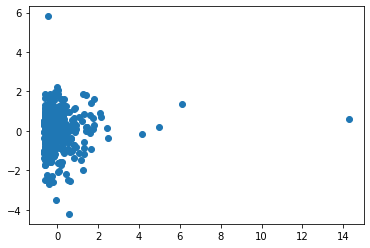

In [51]:
plt.scatter(df["ind_pos"], df["agg_percent"])

<IPython.core.display.Javascript object>


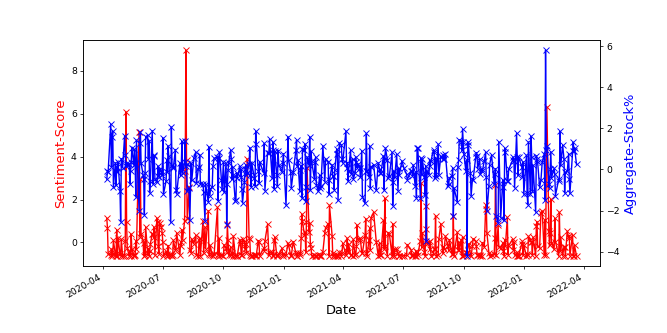

In [54]:
%matplotlib notebook
fig,ax = plt.subplots()
fig.autofmt_xdate()

ax.plot(merged_df.date, df.ind_neg, color="red", marker="x")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Sentiment-Score",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(merged_df.date, df.agg_percent,color="blue",marker="x")
ax2.set_ylabel("Aggregate-Stock%",color="blue",fontsize=14)
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 50
plt.show()


In [12]:
plt.savefig('stock-tweet-scatter.png')

In [11]:
# group by year and month
sample_df = df
sample_df['year'] = sample_df['date'].astype(str).str.slice(0,4)
sample_df['month'] = sample_df['date'].astype(str).str.slice(0,7)
sample_df

grouped_year = sample_df.groupby('year')
grouped_month = sample_df.groupby('month')
grouped_month.get_group('2020-04')

,date,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,agg_percent,year,month
0,2020-04-07,0.519276,1.118305,0.365530,0.381462,1.535990,0.261365,0.406944,-0.472300,2020,2020-04
1,2020-04-08,0.466027,0.656042,0.642934,0.524018,0.232660,-0.073806,1.291336,-0.079544,2020,2020-04
2,2020-04-09,-0.545709,-0.554527,-0.467014,-0.162335,-0.707028,-0.488925,-0.314393,-0.110149,2020,2020-04
3,2020-04-13,-0.412586,-0.582903,-0.352482,0.012589,-0.744663,-0.405968,-0.105235,2.211955,2020,2020-04
4,2020-04-14,-0.013217,-0.305550,0.014498,0.092803,-0.170681,-0.053505,0.117125,0.140424,2020,2020-04
5,2020-04-15,-0.811955,-0.632767,-0.803118,-0.345839,-0.810800,-0.732366,-0.533811,1.604332,2020,2020-04
6,2020-04-16,-0.146340,-0.555969,-0.403809,0.060704,-0.681744,-0.282207,0.347906,1.870845,2020,2020-04
7,2020-04-17,1.850507,0.091649,0.200487,0.920577,1.261458,0.739001,3.116718,-0.842102,2020,2020-04
8,2020-04-20,-0.279463,-0.582479,-0.475538,0.443337,-0.744101,-0.495098,0.409814,0.325963,2020,2020-04
9,2020-04-21,-0.545709,-0.619925,-0.465739,-0.141181,-0.793766,-0.488001,-0.289099,-0.773880,2020,2020-04


In [13]:
for year in sample_df.year.unique():
    temp_df = grouped_year.get_group(year)

    value = temp_df.corr(method="pearson")
    print({year})
    print(value, end="\n\n")

{'2020'}
                count   ind_neg   ind_neu   ind_pos  wted_neg  wted_neu  \
count        1.000000  0.380960  0.661888  0.643256  0.553954  0.903861   
ind_neg      0.380960  1.000000  0.665837  0.620388  0.693339  0.267007   
ind_neu      0.661888  0.665837  1.000000  0.899307  0.401668  0.612837   
ind_pos      0.643256  0.620388  0.899307  1.000000  0.342730  0.484281   
wted_neg     0.553954  0.693339  0.401668  0.342730  1.000000  0.453128   
wted_neu     0.903861  0.267007  0.612837  0.484281  0.453128  1.000000   
wted_pos     0.891205  0.285558  0.565909  0.673401  0.353036  0.636692   
agg_percent -0.012234 -0.014797  0.059990  0.099858 -0.081097 -0.054529   

             wted_pos  agg_percent  
count        0.891205    -0.012234  
ind_neg      0.285558    -0.014797  
ind_neu      0.565909     0.059990  
ind_pos      0.673401     0.099858  
wted_neg     0.353036    -0.081097  
wted_neu     0.636692    -0.054529  
wted_pos     1.000000     0.052402  
agg_percent  0.0524

In [14]:
for month in sample_df.month.unique():
    temp_df = grouped_month.get_group(month)
    value = temp_df.corr(method="pearson")
    print({month})
    print(value, end="\n\n")

{'2020-04'}
                count   ind_neg   ind_neu   ind_pos  wted_neg  wted_neu  \
count        1.000000  0.552996  0.804606  0.889164  0.699392  0.961699   
ind_neg      0.552996  1.000000  0.662153  0.418946  0.898805  0.526241   
ind_neu      0.804606  0.662153  1.000000  0.813908  0.568718  0.823114   
ind_pos      0.889164  0.418946  0.813908  1.000000  0.466622  0.818382   
wted_neg     0.699392  0.898805  0.568718  0.466622  1.000000  0.677805   
wted_neu     0.961699  0.526241  0.823114  0.818382  0.677805  1.000000   
wted_pos     0.959006  0.397295  0.733330  0.921623  0.529995  0.864994   
agg_percent -0.103627 -0.099827 -0.054229  0.026219 -0.139797 -0.127583   

             wted_pos  agg_percent  
count        0.959006    -0.103627  
ind_neg      0.397295    -0.099827  
ind_neu      0.733330    -0.054229  
ind_pos      0.921623     0.026219  
wted_neg     0.529995    -0.139797  
wted_neu     0.864994    -0.127583  
wted_pos     1.000000    -0.060573  
agg_percent -0.0

In [15]:
# group by year and month
sample_df = df
sample_df['year'] = sample_df['date'].astype(str).str.slice(0,4)
sample_df['month'] = sample_df['date'].astype(str).str.slice(0,7)
sample_df

grouped_year = sample_df.groupby('year')
grouped_month = sample_df.groupby('month')
grouped_month.get_group('2020-04')

,date,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,agg_percent,year,month
0,2020-04-07,0.519276,1.118305,0.365530,0.381462,1.535990,0.261365,0.406944,-0.472300,2020,2020-04
1,2020-04-08,0.466027,0.656042,0.642934,0.524018,0.232660,-0.073806,1.291336,-0.079544,2020,2020-04
2,2020-04-09,-0.545709,-0.554527,-0.467014,-0.162335,-0.707028,-0.488925,-0.314393,-0.110149,2020,2020-04
3,2020-04-13,-0.412586,-0.582903,-0.352482,0.012589,-0.744663,-0.405968,-0.105235,2.211955,2020,2020-04
4,2020-04-14,-0.013217,-0.305550,0.014498,0.092803,-0.170681,-0.053505,0.117125,0.140424,2020,2020-04
5,2020-04-15,-0.811955,-0.632767,-0.803118,-0.345839,-0.810800,-0.732366,-0.533811,1.604332,2020,2020-04
6,2020-04-16,-0.146340,-0.555969,-0.403809,0.060704,-0.681744,-0.282207,0.347906,1.870845,2020,2020-04
7,2020-04-17,1.850507,0.091649,0.200487,0.920577,1.261458,0.739001,3.116718,-0.842102,2020,2020-04
8,2020-04-20,-0.279463,-0.582479,-0.475538,0.443337,-0.744101,-0.495098,0.409814,0.325963,2020,2020-04
9,2020-04-21,-0.545709,-0.619925,-0.465739,-0.141181,-0.793766,-0.488001,-0.289099,-0.773880,2020,2020-04


In [16]:
for year in sample_df.year.unique():
    temp_df = grouped_year.get_group(year)
    value = temp_df.corr(method="pearson")
    print({year})
    print(value, end="\n\n")

{'2020'}
                count   ind_neg   ind_neu   ind_pos  wted_neg  wted_neu  \
count        1.000000  0.380960  0.661888  0.643256  0.553954  0.903861   
ind_neg      0.380960  1.000000  0.665837  0.620388  0.693339  0.267007   
ind_neu      0.661888  0.665837  1.000000  0.899307  0.401668  0.612837   
ind_pos      0.643256  0.620388  0.899307  1.000000  0.342730  0.484281   
wted_neg     0.553954  0.693339  0.401668  0.342730  1.000000  0.453128   
wted_neu     0.903861  0.267007  0.612837  0.484281  0.453128  1.000000   
wted_pos     0.891205  0.285558  0.565909  0.673401  0.353036  0.636692   
agg_percent -0.012234 -0.014797  0.059990  0.099858 -0.081097 -0.054529   

             wted_pos  agg_percent  
count        0.891205    -0.012234  
ind_neg      0.285558    -0.014797  
ind_neu      0.565909     0.059990  
ind_pos      0.673401     0.099858  
wted_neg     0.353036    -0.081097  
wted_neu     0.636692    -0.054529  
wted_pos     1.000000     0.052402  
agg_percent  0.0524

In [17]:
for month in sample_df.month.unique():
    temp_df = grouped_month.get_group(month)
    value = temp_df.corr(method="pearson")
    print({month})
    print(value, end="\n\n")

{'2020-04'}
                count   ind_neg   ind_neu   ind_pos  wted_neg  wted_neu  \
count        1.000000  0.552996  0.804606  0.889164  0.699392  0.961699   
ind_neg      0.552996  1.000000  0.662153  0.418946  0.898805  0.526241   
ind_neu      0.804606  0.662153  1.000000  0.813908  0.568718  0.823114   
ind_pos      0.889164  0.418946  0.813908  1.000000  0.466622  0.818382   
wted_neg     0.699392  0.898805  0.568718  0.466622  1.000000  0.677805   
wted_neu     0.961699  0.526241  0.823114  0.818382  0.677805  1.000000   
wted_pos     0.959006  0.397295  0.733330  0.921623  0.529995  0.864994   
agg_percent -0.103627 -0.099827 -0.054229  0.026219 -0.139797 -0.127583   

             wted_pos  agg_percent  
count        0.959006    -0.103627  
ind_neg      0.397295    -0.099827  
ind_neu      0.733330    -0.054229  
ind_pos      0.921623     0.026219  
wted_neg     0.529995    -0.139797  
wted_neu     0.864994    -0.127583  
wted_pos     1.000000    -0.060573  
agg_percent -0.0